In [42]:
# Imports

import pandas as pd
import numpy as np
import warnings
from plotnine import *
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
# Read Data

filepath = 'data/AirPassengers.csv'
data = pd.read_csv(filepath)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='#Passengers'>)

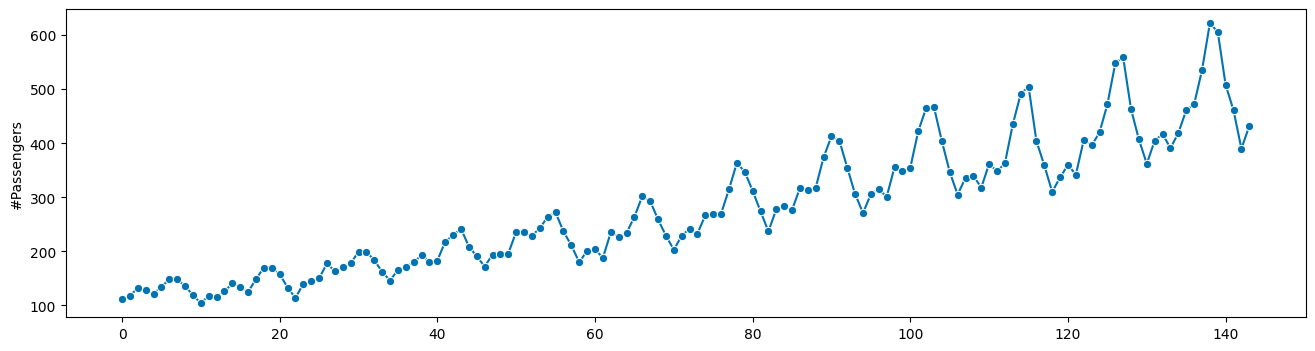

In [4]:
plot_series(data['#Passengers'])

In [33]:
# Train Test Split

TEST_SIZE = 24
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
train

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
115,1958-08,505
116,1958-09,404
117,1958-10,359
118,1958-11,310


In [11]:
# Naive Forecasting - Training

model = NaiveForecaster(strategy='last', sp=12)
model.fit(train['#Passengers'])

NaiveForecaster(sp=12)

MAPE: 0.15523355162420377


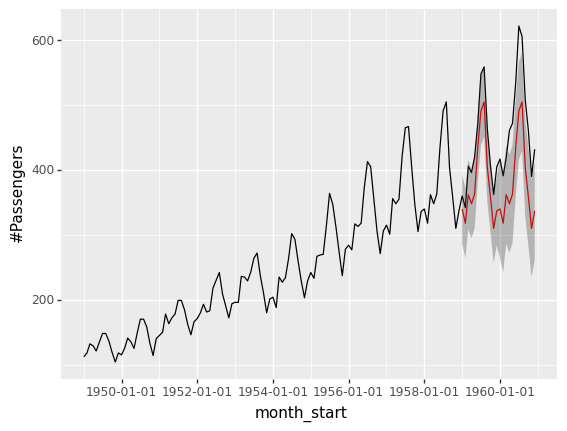

<ggplot: (8763139737302)>

In [50]:
# Test Prediction - Plot

fh = np.arange(1, TEST_SIZE+1)
test_pred = model.predict(fh=fh)
interval = model.predict_interval()
interval.columns = ['ll', 'ul']

plot_data = data.copy(deep=False)
test_pred = pd.DataFrame(test_pred.values, columns=['test_forecast'], index=test_pred.index)
plot_data = plot_data.join(test_pred, how='left')
plot_data = plot_data.join(interval, how='left')
plot_data['month_start'] = pd.to_datetime(plot_data['Month'])

mape = mean_absolute_percentage_error(test['#Passengers'], test_pred)
print(f'MAPE: {mape}')


plot = (ggplot(plot_data) + 
        geom_line(aes(x='month_start', y='#Passengers')) +
        geom_line(aes(x='month_start', y='test_forecast'), color='red') +
        geom_ribbon(aes(x='month_start', ymax='ul', ymin='ll'), alpha=0.3)
)
plot


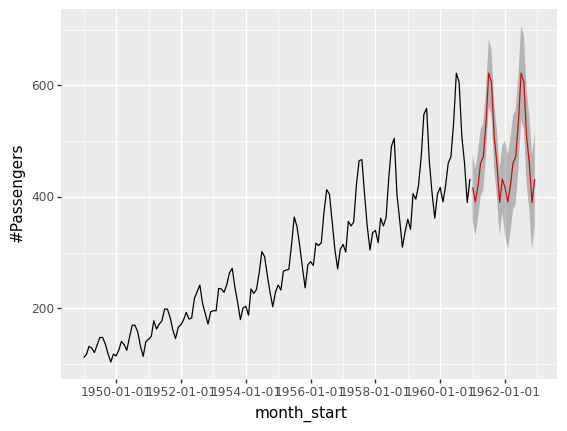

<ggplot: (8763139989080)>

In [57]:
# Future Prediction

FORECAST_HORIZON = 24
model = NaiveForecaster(strategy='last', sp=12)
model.fit(data['#Passengers'])

fh = np.arange(1, TEST_SIZE+1)
test_pred = model.predict(fh=fh)
interval = model.predict_interval()
interval.columns = ['ll', 'ul']

data['month_start'] = pd.to_datetime(data['Month'])
future_frame = pd.DataFrame(pd.date_range(start=data['month_start'].iloc[-1] + pd.DateOffset(months=1),
                                          periods=24,
                                          freq='MS'),
                             columns=['month_start'],
                             index=range(data.index[-1]+1, data.index[-1]+FORECAST_HORIZON+1))
future_frame['prediction'] = test_pred
future_frame = future_frame.join(interval, how='left')

plot_data = pd.concat([data, future_frame], axis=0)
plot = (ggplot(plot_data) + 
        geom_line(aes(x='month_start', y='#Passengers')) +
        geom_line(aes(x='month_start', y='prediction'), color='red') +
        geom_ribbon(aes(x='month_start', ymax='ul', ymin='ll'), alpha=0.3)
)
plot           